In [2]:
!pip install gdown
!pip install tensorflow
!pip install --upgrade opencv-python

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn.model_selection
import random
from tensorflow.keras import layers, Model

In [2]:
# to download from
file_id = "1PyxqW_nsORX4PetkQo6OIL0mUL1pFsTD"
!gdown --id {file_id} -O rare_species.zip



/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1PyxqW_nsORX4PetkQo6OIL0mUL1pFsTD
From (redirected): https://drive.google.com/uc?id=1PyxqW_nsORX4PetkQo6OIL0mUL1pFsTD&confirm=t&uuid=3e769b56-eef4-468d-8f31-fa2b9b2aaff4
To: /content/rare_species.zip
100% 4.26G/4.26G [00:49<00:00, 85.5MB/s]


In [3]:
# verify file size
!ls -lh rare_species.zip

-rw-r--r-- 1 root root 4.0G Mar 10 10:29 rare_species.zip


In [4]:
# directory creation for excation
extract_path = '/content/rare_species'
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    print(f"Created directory: {extract_path}")

In [5]:
# extraction
print("Extracting zip ")
with zipfile.ZipFile('rare_species.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete")

Extracting zip 
Extraction complete


In [6]:
# list fo contents for double-check
!ls -la {extract_path}

total 2924
drwxr-xr-x 204 root root   12288 Apr  1 12:56 .
drwxr-xr-x   1 root root    4096 Apr  1 13:52 ..
drwxr-xr-x   2 root root   12288 Apr  1 12:56 arthropoda_apidae
drwxr-xr-x   2 root root    4096 Apr  1 12:56 arthropoda_attelabidae
drwxr-xr-x   2 root root    4096 Apr  1 12:56 arthropoda_carabidae
drwxr-xr-x   2 root root    4096 Apr  1 12:56 arthropoda_cerambycidae
drwxr-xr-x   2 root root    4096 Apr  1 12:56 arthropoda_coenagrionidae
drwxr-xr-x   2 root root   28672 Apr  1 12:56 arthropoda_formicidae
drwxr-xr-x   2 root root    4096 Apr  1 12:56 arthropoda_gomphidae
drwxr-xr-x   2 root root    4096 Apr  1 12:56 arthropoda_lucanidae
drwxr-xr-x   2 root root    4096 Apr  1 12:56 arthropoda_nymphalidae
drwxr-xr-x   2 root root    4096 Apr  1 12:56 arthropoda_palinuridae
drwxr-xr-x   2 root root    4096 Apr  1 12:55 arthropoda_papilionidae
drwxr-xr-x   2 root root    4096 Apr  1 12:56 arthropoda_pisauridae
drwxr-xr-x   2 root root    4096 Apr  1 12:56 arthropoda_platystictidae


In [7]:
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]
print(f"Found CSV files: {csv_files}")

if csv_files:
    metadata_path = os.path.join(extract_path, csv_files[0])
    metadata = pd.read_csv(metadata_path)
    print(f"Loaded metadata with shape: {metadata.shape}")
    print(metadata.head())
else:
    print("No CSV file found.")

Found CSV files: ['metadata.csv']
Loaded metadata with shape: (11983, 7)
                        rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_tur

# EDA

In [9]:
metadata.head(20)

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...
5,dc48f2ce-4feb-4ef7-b2a2-c3c3f42bf19b,28657539,491832,animalia,arthropoda,formicidae,arthropoda_formicidae/28657539_491832_eol-full...
6,3d881320-8ba8-4580-a72c-0e7ab116b664,29548208,47043290,animalia,chordata,fringillidae,chordata_fringillidae/29548208_47043290_eol-fu...
7,7faca96a-54e6-4c80-b9e4-77ab126d904a,21232818,1033999,animalia,arthropoda,gomphidae,arthropoda_gomphidae/21232818_1033999_eol-full...
8,9f89ecab-aabd-41a4-b5b4-8ce106d85959,20315204,46561012,animalia,chordata,myliobatidae,chordata_myliobatidae/20315204_46561012_eol-fu...
9,b6ec7a70-c470-4ede-8930-05844e1efd2e,20124498,46570095,animalia,chordata,pleuronectidae,chordata_pleuronectidae/20124498_46570095_eol-...


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11983 entries, 0 to 11982
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   rare_species_id  11983 non-null  object
 1   eol_content_id   11983 non-null  int64 
 2   eol_page_id      11983 non-null  int64 
 3   kingdom          11983 non-null  object
 4   phylum           11983 non-null  object
 5   family           11983 non-null  object
 6   file_path        11983 non-null  object
 7   file_exists      11983 non-null  bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 667.2+ KB


In [ ]:
print("number of duplicate in the dataset :", metadata.duplicated().sum())
print("number of duplicate in 'rare_species_id' :", metadata.duplicated(subset=['rare_species_id']).sum())
print("number of duplicate 'file_path' :", metadata.duplicated(subset=['file_path']).sum())

number of duplicate in the dataset : 0
number of duplicate in 'rare_species_id' : 0
number of duplicate 'file_path' : 0


In [ ]:
metadata.nunique()

,0
rare_species_id,11983
eol_content_id,11983
eol_page_id,400
kingdom,1
phylum,5
family,202
file_path,11983


In [ ]:
print("Missing values check :", metadata.isnull().sum())

Missing values check : rare_species_id    0
eol_content_id     0
eol_page_id        0
kingdom            0
phylum             0
family             0
file_path          0
dtype: int64


In [ ]:
metadata.describe(include="object")

,rare_species_id,kingdom,phylum,family,file_path
count,11983,11983,11983,11983,11983
unique,11983,1,5,202,11983
top,54894a59-151f-4814-ac32-3a336841e58e,animalia,chordata,dactyloidae,chordata_lemuridae/9465817_326525_eol-full-siz...
freq,1,11983,9952,300,1


In [ ]:
metadata.describe(include ='int64')

,eol_content_id,eol_page_id
count,1.198300e+04,1.198300e+04
mean,2.297681e+07,2.112247e+07
std,6.999289e+06,2.241319e+07
min,4.750000e+02,1.180080e+05
25%,2.058937e+07,7.954560e+05
50%,2.251368e+07,2.865857e+06
75%,2.932887e+07,4.551773e+07
max,3.061946e+07,5.269200e+07


Class distribution analysis

Number of unique families: 202
Top 10 most common families:
family
dactyloidae        300
cercopithecidae    300
formicidae         291
carcharhinidae     270
salamandridae      270
plethodontidae     270
bovidae            240
bucerotidae        210
acroporidae        210
diomedeidae        180
Name: count, dtype: int64


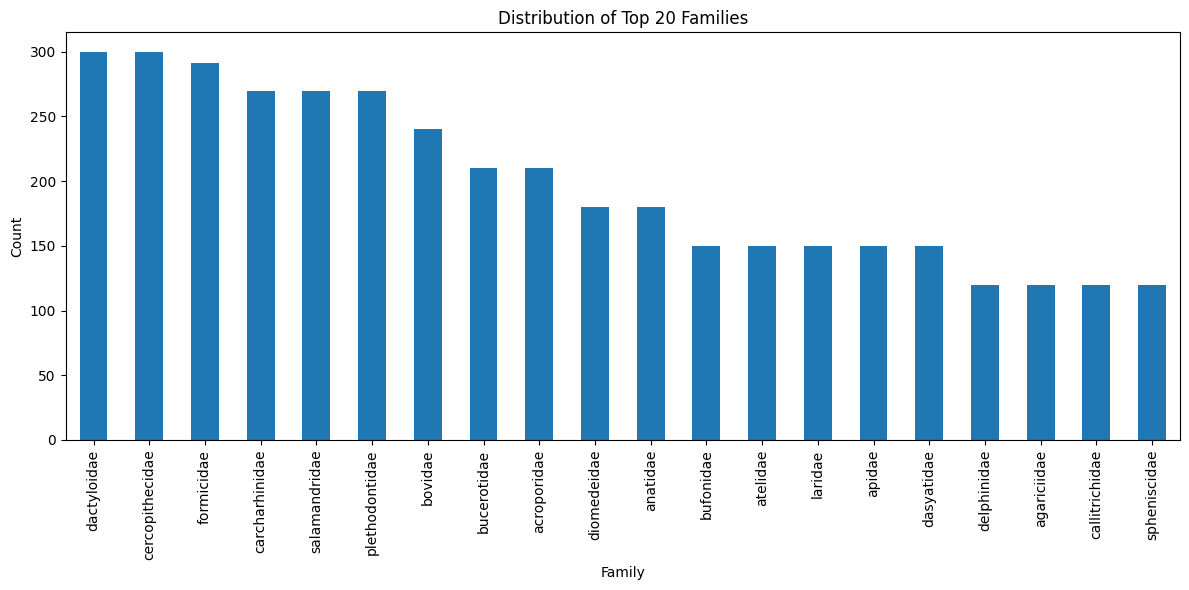

In [ ]:
# defining processed data directory and raw data_dir
DATA_DIR = '/content/rare_species'
processed_data_path = '/content/processed_data'

if not os.path.exists(processed_data_path):
    os.makedirs(processed_data_path)

# image distribution by family
if 'family' in metadata.columns:
    family_counts = metadata['family'].value_counts()
    print(f"Number of unique families: {len(family_counts)}")
    print("Top 10 most common families:")
    print(family_counts.head(10))

    # family distribution plot
    plt.figure(figsize=(12, 6))
    family_counts.head(20).plot(kind='bar')
    plt.title('Distribution of Top 20 Families')
    plt.xlabel('Family')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


Number of unique phylums: 5
phylum distribution:
phylum
chordata         9952
arthropoda        951
cnidaria          810
mollusca          210
echinodermata      60
Name: count, dtype: int64


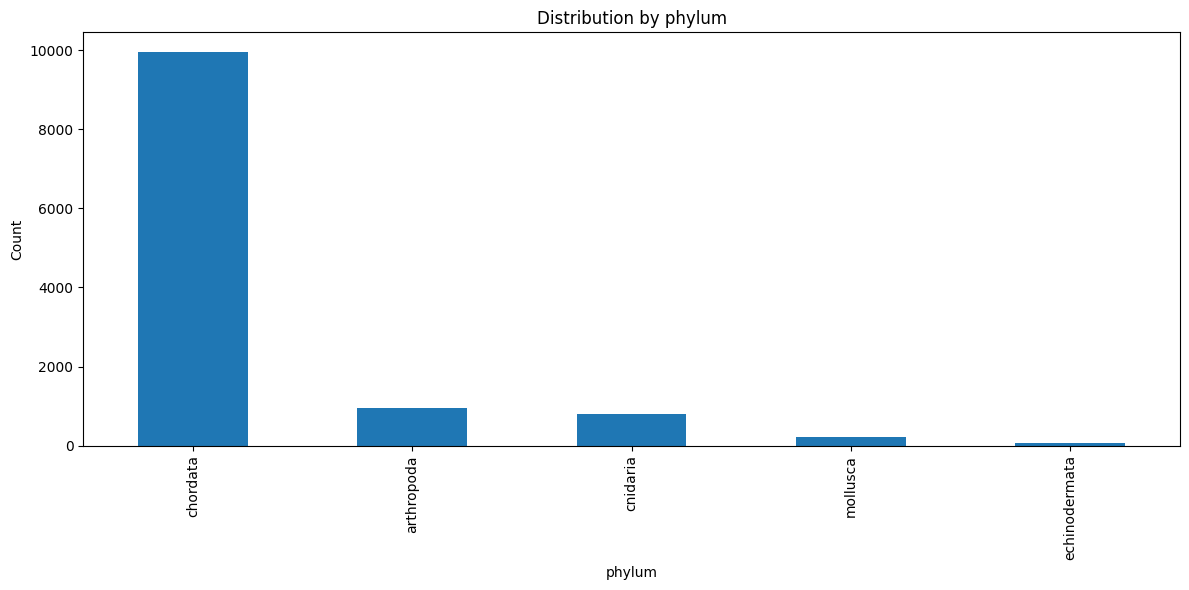

In [ ]:
# image distribution by phylum
if 'phylum' in metadata.columns:
    phylum_counts = metadata['phylum'].value_counts()
    print(f"Number of unique phylums: {len(phylum_counts)}")
    print("phylum distribution:")
    print(phylum_counts.head())

    # family distribution plot
    plt.figure(figsize=(12, 6))
    phylum_counts.plot(kind='bar')
    plt.title('Distribution by phylum')
    plt.xlabel('phylum')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Total number of images : 11983
Total number of families :
phylum
arthropoda        17
chordata         166
cnidaria          13
echinodermata      1
mollusca           5
dtype: int64


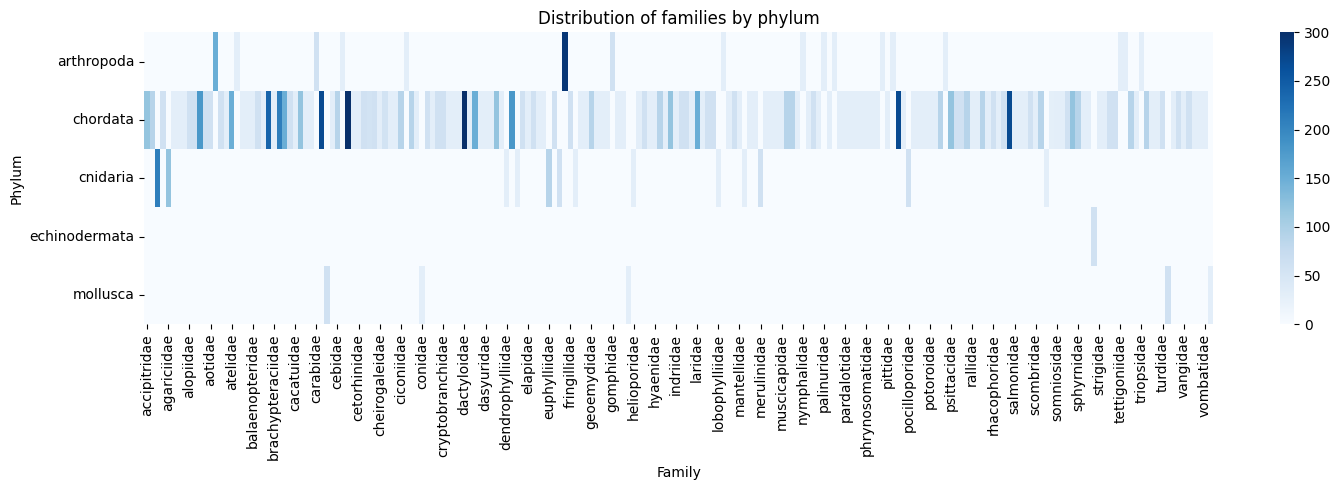

In [ ]:
# We do a cross table to check how families are distributed in phylum
pivot_table = pd.pivot_table(metadata,
                             index='phylum',
                             columns='family',
                             aggfunc='size',
                             fill_value=0)

# Stats rapides
print(f"Total number of images : {pivot_table.values.sum()}")
print("Total number of families :")
print(pivot_table.astype(bool).sum(axis=1))  # Nombre de familles non vides par phylum

# Visualisation
plt.figure(figsize=(15, 5))
sns.heatmap(pivot_table, cmap='Blues', annot=False)  # annot=True for the numbers
plt.title('Distribution of families by phylum')
plt.xlabel('Family')
plt.ylabel('Phylum')
plt.tight_layout()
plt.show()

Image Quality and Resolution check

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Image Resolution Analysis:
Unique resolutions: 5229
Average width: 1924.6 ± 1267.5
Average height: 1512.3 ± 951.3

Format distribution:
JPEG    11983
Name: count, dtype: int64


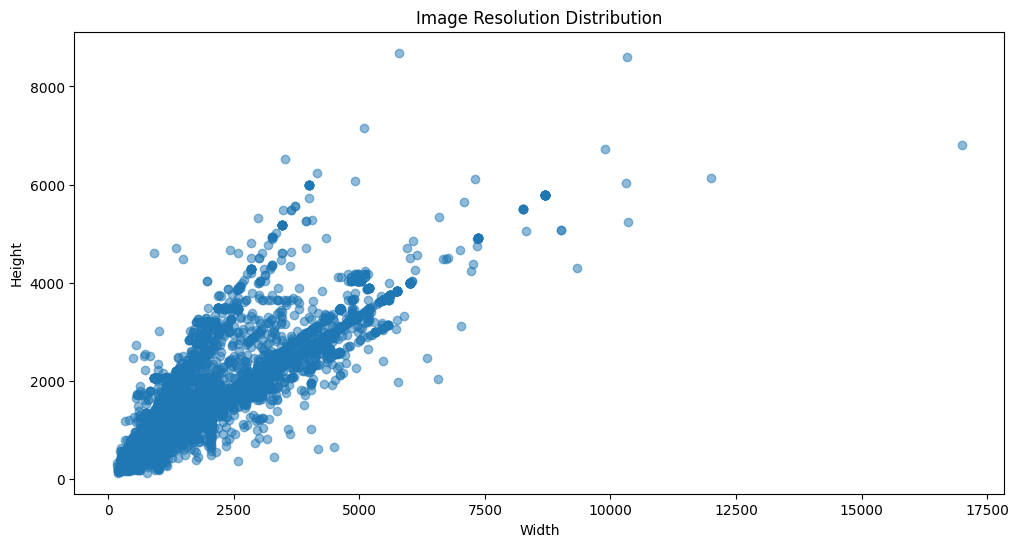

In [ ]:
if 'file_path' in metadata.columns:
    # Analyze image dimensions
    resolutions = []
    formats = []

    for idx, row in metadata.iterrows():
        img_path = os.path.join(DATA_DIR, row['file_path'])
        try:
            with Image.open(img_path) as img:
                resolutions.append(img.size)
                formats.append(img.format)
        except:
            continue

    # Calculate statistics
    unique_resolutions = pd.Series(resolutions).value_counts()
    width, height = zip(*resolutions)

    print("\nImage Resolution Analysis:")
    print(f"Unique resolutions: {len(unique_resolutions)}")
    print(f"Average width: {np.mean(width):.1f} ± {np.std(width):.1f}")
    print(f"Average height: {np.mean(height):.1f} ± {np.std(height):.1f}")
    print("\nFormat distribution:")
    print(pd.Series(formats).value_counts())

    # Visualize resolution distribution
    plt.figure(figsize=(12, 6))
    plt.scatter(width, height, alpha=0.5)
    plt.title('Image Resolution Distribution')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.show()

Color Distribution Across Species

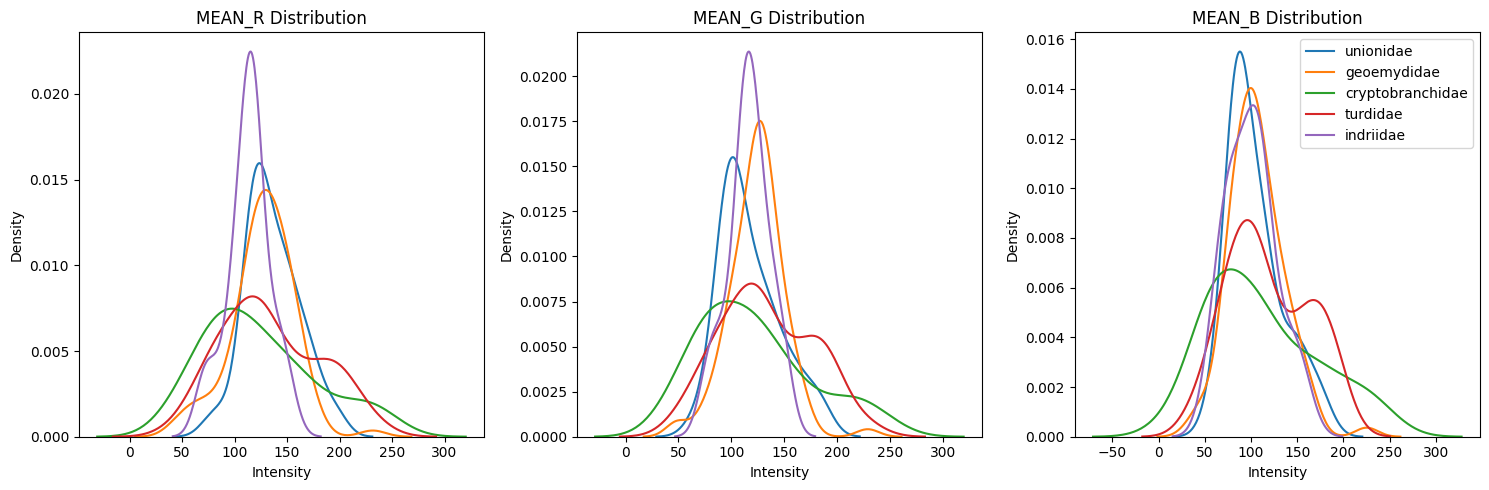

In [ ]:
import seaborn as sns
if 'family' in metadata.columns:
    # Calculate color statistics
    color_stats = []

    for idx, row in metadata.iterrows():
        img_path = os.path.join(DATA_DIR, row['file_path'])
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            color_stats.append({
                'family': row['family'],
                'mean_r': np.mean(img[:,:,0]),
                'mean_g': np.mean(img[:,:,1]),
                'mean_b': np.mean(img[:,:,2])
            })
        except:
            continue

    color_df = pd.DataFrame(color_stats)

    # color distributionp plot
    plt.figure(figsize=(15, 5))
    for i, channel in enumerate(['mean_r', 'mean_g', 'mean_b']):
        plt.subplot(1, 3, i+1)
        for family in color_df['family'].unique()[:5]:  # Top 5 families
            sns.kdeplot(color_df[color_df['family'] == family][channel], label=family)
        plt.title(f'{channel.upper()} Distribution')
        plt.xlabel('Intensity')
    plt.tight_layout()
    plt.legend()
    plt.show()

Shape & Texture features

In [ ]:
plt.figure(figsize=(15, 10))
for i, (idx, row) in enumerate(metadata.iterrows(), 1):  # Iterate through ALL rows
    img_path = os.path.join(DATA_DIR, row['file_path'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(len(metadata), 2, i*2-1)  # Dynamic subplot sizing
    plt.imshow(img, cmap='gray')
    plt.title(f'Original: {row["family"]}')

# edge detection

    edges = cv2.Canny(img, 100, 200)
    plt.subplot(len(metadata), 2, i*2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')

plt.tight_layout()
plt.show()

# texture analysis

texture_features = []
for idx, row in metadata.iterrows():
    img_path = os.path.join(DATA_DIR, row['file_path'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        texture_features.append({
            'family': row['family'],
            'contrast': feature.greycoprops(feature.greycomatrix(img, [1], [0]), 'contrast')[0][0],
            'entropy': shannon_entropy(img)
        })

texture_df = pd.DataFrame(texture_features)

# texture features plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='family', y='contrast', data=texture_df[texture_df['family'].isin(texture_df['family'].value_counts().index[:5])])
plt.title('Texture Contrast Distribution by Family')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# function to preprocess 1 image
def preprocess_image(image_path, target_size=(224, 224)):
    try:
        img = Image.open(image_path)
        img = img.convert('RGB')  # Convert to RGB in case of RGBA or grayscale
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize to [0,1]
        return img_array, True
    except Exception as e:
        try:
            img = cv2.imread(image_path)
            if img is None:
                return None, False
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, target_size)
            img_array = img.astype(np.float32) / 255.0
            return img_array, True
        except Exception as e2:
            print(f"Failed to process {image_path}: {e2}")
            return None, False

In [ ]:
# function to create train/val/test splits
def create_data_splits(metadata, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, stratify_col='family'):
    from sklearn.model_selection import train_test_split


    train_data, temp_data = train_test_split(
        metadata,
        train_size=train_ratio,
        random_state=42,
        stratify=metadata[stratify_col] if stratify_col in metadata.columns else None
    )

    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_data, test_data = train_test_split(
        temp_data,
        train_size=val_ratio_adjusted,
        random_state=42,
        stratify=temp_data[stratify_col] if stratify_col in metadata.columns else None
    )

    print(f"Data splits created - Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")
    return train_data, val_data, test_data

In [ ]:
# data splits
if 'family' in metadata.columns:
    train_data, val_data, test_data = create_data_splits(metadata)

    # savings splits for baseline score
    train_data.to_csv(f'{processed_data_path}/train_metadata.csv', index=False)
    val_data.to_csv(f'{processed_data_path}/val_metadata.csv', index=False)
    test_data.to_csv(f'{processed_data_path}/test_metadata.csv', index=False)

Data splits created - Train: 8388, Validation: 1797, Test: 1798


In [ ]:
# process a small batch to test the pipeline and understand image characteristics
def process_sample_batch(metadata_sample, base_path):
    sample_images = []
    failed_images = []

    for idx, row in tqdm(metadata_sample.iterrows(), total=len(metadata_sample)):
        if 'file_path' in row:
            image_path = os.path.join(base_path, row['file_path'])
        else:
            image_path = os.path.join(base_path, f"{row['family']}/{row['species']}.jpg")

        img_array, success = preprocess_image(image_path)
        if success:
            sample_images.append(img_array)
        else:
            failed_images.append(image_path)

    print(f"Processed {len(sample_images)} images successfully, {len(failed_images)} failed")
    return sample_images, failed_images

# sample a small batch to test
sample_size = 10
metadata_sample = metadata.sample(sample_size)
sample_images, failed_images = process_sample_batch(metadata_sample, extract_path)

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# visualizing images
if sample_images:
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(sample_images))):
        plt.subplot(1, 5, i+1)
        plt.imshow(sample_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Preprocessing

In [8]:
DATA_DIR = '/content/rare_species'
metadata = pd.read_csv(DATA_DIR + '/metadata.csv')  # Load metadata from csv

# Check if files exist before splitting
metadata['file_exists'] = metadata['file_path'].apply(lambda x: os.path.exists(DATA_DIR + '/' + x))  # Check the existing files
metadata = metadata[metadata['file_exists']]
print('Total valid entries:', len(metadata))  # Print the size of the valid files

Total valid entries: 11983


In [9]:
# Split train/val/test
train_data, temp_data = sklearn.model_selection.train_test_split(
    metadata, test_size=0.3, stratify=metadata['family'], random_state=42
)
val_data, test_data = sklearn.model_selection.train_test_split(
    temp_data, test_size=0.5, stratify=temp_data['family'], random_state=42
)

# check sizes
train_size, val_size, test_size, total_size = len(train_data), len(val_data), len(test_data), len(metadata)
print('Train:', train_size, f'({round(train_size/total_size*100, 1)}%)')
print('Val:', val_size, f'({round(val_size/total_size*100, 1)}%)')
print('Test:', test_size, f'({round(test_size/total_size*100, 1)}%)')

Train: 8388 (70.0%)
Val: 1797 (15.0%)
Test: 1798 (15.0%)


In [10]:
# check families distribution
print('\nDistribution family in train (top 5):\n', train_data['family'].value_counts().head())
print('\nDistribution family in val (top 5):\n', val_data['family'].value_counts().head())
print('\nDistribution family in test (top 5):\n', test_data['family'].value_counts().head())



Distribution family in train (top 5):
 family
dactyloidae        210
cercopithecidae    210
formicidae         204
carcharhinidae     189
plethodontidae     189
Name: count, dtype: int64

Distribution family in val (top 5):
 family
cercopithecidae    45
dactyloidae        45
formicidae         43
salamandridae      40
carcharhinidae     40
Name: count, dtype: int64

Distribution family in test (top 5):
 family
cercopithecidae    45
dactyloidae        45
formicidae         44
carcharhinidae     41
plethodontidae     41
Name: count, dtype: int64


In [11]:
# Encoding
family_encoder = pd.factorize(metadata['family'])[1]  # 202 families
phylum_encoder = pd.factorize(metadata['phylum'])[1]  # 5 phylum
num_phyla = len(phylum_encoder)
num_families = len(family_encoder)

# labels conversion
train_labels = [family_encoder.get_loc(f) for f in train_data['family']]
val_labels = [family_encoder.get_loc(f) for f in val_data['family']]
test_labels = [family_encoder.get_loc(f) for f in test_data['family']]
train_phylum = [phylum_encoder.get_loc(p) for p in train_data['phylum']]
val_phylum = [phylum_encoder.get_loc(p) for p in val_data['phylum']]
test_phylum = [phylum_encoder.get_loc(p) for p in test_data['phylum']]

Let's try to take in consideration phylum as an input and do the preprocessing.
The preprocesing is done separately on train and evaluation datasets to avoid data leakage.
First, we're doing augmentation on the training for all classes: rare families and common ones. After, we'll do a targeted augmentation only to the rare families and compare both results.

(according to reddit it's better to go for the global augmentation and then play with the classes weights, as this approach makes the common classes more robust and make the rare ones more "seen" cause even if the ratio stays the same but we will adjust that on the weights)


In [14]:
# Fonctions de prétraitement
def preprocess_image_train(image_path, phylum_label, family_label, target_size=(224, 224)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = img / 255.0
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_hue(img, 0.1)
#    img = tf.image.random_rotation(img, 0.2)  # i have an issue here, pls try to run it without the #
    img = tf.clip_by_value(img, 0.0, 1.0)
    return (img, phylum_label), family_label

def preprocess_image_eval(image_path, phylum_label, family_label, target_size=(224, 224)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.image.adjust_contrast(img, 1.2)
    img = img / 255.0
    return (img, phylum_label), family_label

In [15]:
# Datasets with global augmentation
train_paths = [os.path.join(DATA_DIR, path) for path in train_data['file_path']]
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_phylum, train_labels))
train_dataset = train_dataset.map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_paths = [os.path.join(DATA_DIR, path) for path in val_data['file_path']]
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_phylum, val_labels))
val_dataset = val_dataset.map(preprocess_image_eval, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_paths = [os.path.join(DATA_DIR, path) for path in test_data['file_path']]
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_phylum, test_labels))
test_dataset = test_dataset.map(preprocess_image_eval, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
# check the first batch
for (img_batch, phylum_batch), label_batch in train_dataset.take(1):
    print('Shape of image batch:', img_batch.shape)  # (32, 224, 224, 3)
    print('Shape of phylum batch:', phylum_batch.shape)  # (32,)
    print('Shape of label batch:', label_batch.shape)  # (32,)

Shape of image batch: (32, 224, 224, 3)
Shape of phylum batch: (32,)
Shape of label batch: (32,)


**preprocess check:**


In order to see if our preprocessing was effective we:
- check visually the images
- check its performance on a model (just a draft, we'll delete this model as we're just trying. But we'll mention this step on the report)

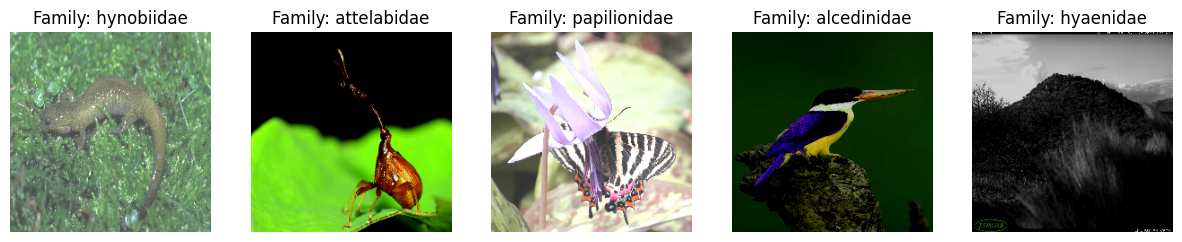

In [17]:
# we select some random images from train
for (img_batch, phylum_batch), label_batch in train_dataset.take(1):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(img_batch[i].numpy())
        label = int(label_batch[i].numpy())
        plt.title(f"Family: {family_encoder[label]}")
        plt.axis('off')
    plt.show()
    break

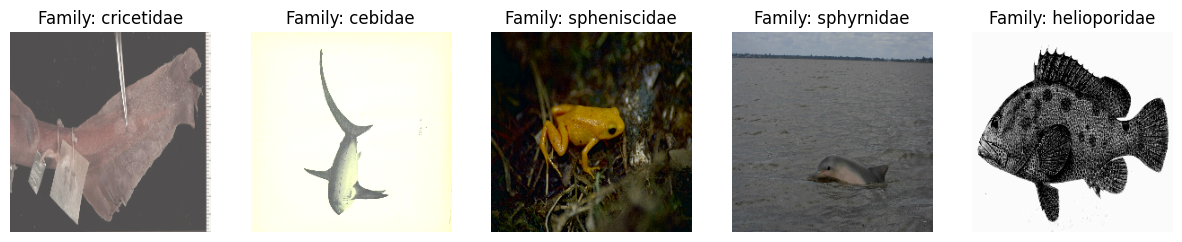

--- Nouvel essai ---


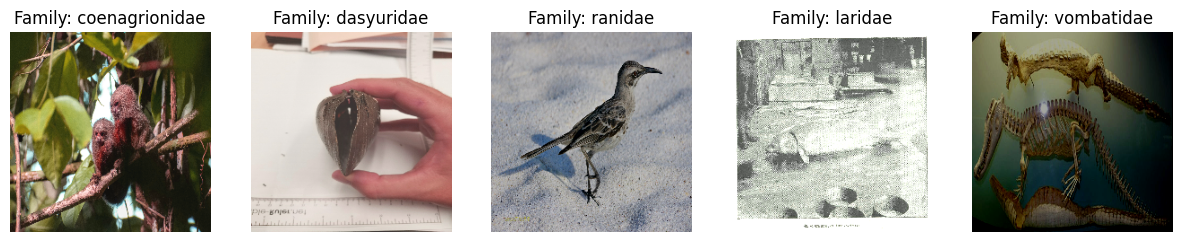

--- Nouvel essai ---


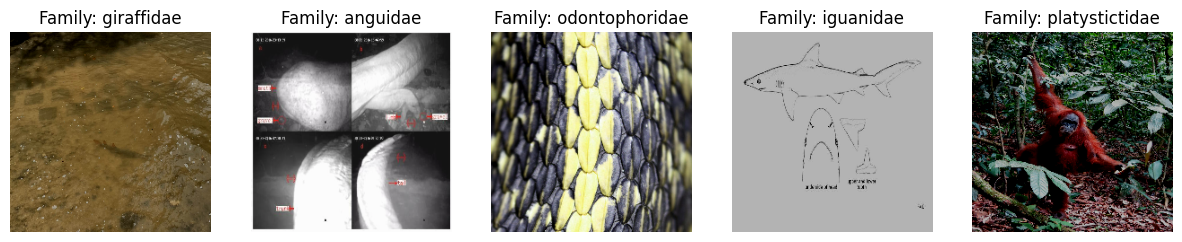

--- Nouvel essai ---


In [21]:
#just because i want mooooore images
for _ in range(3):
    for (img_batch, phylum_batch), label_batch in train_dataset.take(1):
        plt.figure(figsize=(15, 3))
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.imshow(img_batch[i].numpy())
            label = int(label_batch[i].numpy())
            plt.title(f"Family: {family_encoder[label]}")
            plt.axis('off')
        plt.show()
    print("--- Nouvel essai ---")

In [18]:
# building the model
image_input = layers.Input(shape=(224, 224, 3), name='image_input')
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
image_branch = layers.Dense(256, activation='relu')(x)

phylum_input = layers.Input(shape=(1,), name='phylum_input')
y = layers.Embedding(num_phyla, 10)(phylum_input)
y = layers.Flatten()(y)
phylum_branch = layers.Dense(16, activation='relu')(y)

combined = layers.concatenate([image_branch, phylum_branch])
z = layers.Dense(128, activation='relu')(combined)
z = layers.Dropout(0.5)(z)
output = layers.Dense(num_families, activation='softmax')(z)  # 202 classes

model = Model(inputs=[image_input, phylum_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 222, 222, 32)   │            896 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 111, 111, 32)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 54, 54, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 52, 52, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ phylum_input (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 26, 26, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 10)          │             50 │ phylum_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 86528)          │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 10)             │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │     22,151,424 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │            176 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 272)            │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         34,944 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 202)            │         26,058 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 22,305,900 (85.09 MB)

 Trainable params: 22,305,900 (85.09 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# train with global augmentation
history_global = model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

print("Résultats avec augmentation globale :")
print("Train accuracy:", history_global.history['accuracy'][-1])
print("Val accuracy:", history_global.history['val_accuracy'][-1])

Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 238s 806ms/step - accuracy: 0.0271 - loss: 5.2112 - val_accuracy: 0.0879 - val_loss: 4.6978
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 210s 728ms/step - accuracy: 0.0809 - loss: 4.6676 - val_accuracy: 0.1057 - val_loss: 4.3552
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 207s 728ms/step - accuracy: 0.0972 - loss: 4.4007 - val_accuracy: 0.1091 - val_loss: 4.2276
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 194s 667ms/step - accuracy: 0.1145 - loss: 4.2509 - val_accuracy: 0.1230 - val_loss: 4.1238
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 205s 720ms/step - accuracy: 0.1360 - loss: 4.0910 - val_accuracy: 0.1358 - val_loss: 4.0717
Résultats avec augmentation globale :
Train accuracy: 0.13721983134746552
Val accuracy: 0.13578185439109802


The model is learning, but slowly as the accuracy is increasing but is still very low.
One of the issue i suspect is the image rotation:
the function "img = tf.image.random_rotation(img, 0.2)" is not working on my computer and i still cant find where is the issue. I put it on # on the preprocessing pipeline try to run it and then run the model pls (add more epochs too if you want)

**targeted augmentation**


Ok now let's apply augmentation only on the rarest families:
Let's consider a family plant as a "rare family" if it has less than 35 images. (I chosed 35 because it's the average of number of families by image (202/11983=35),
 ut it can be more maybe?)

In [20]:
# Targeted augmentation for rare families (< 35 images)
family_counts = train_data['family'].value_counts()
rare_families = family_counts[family_counts < 35].index
rare_data = train_data[train_data['family'].isin(rare_families)]
common_data = train_data[~train_data['family'].isin(rare_families)]

In [21]:
# Dataset for rare families
rare_paths = [os.path.join(DATA_DIR, path) for path in rare_data['file_path']]
rare_phylum = [phylum_encoder.get_loc(p) for p in rare_data['phylum']]
rare_labels = [family_encoder.get_loc(f) for f in rare_data['family']]
rare_dataset = tf.data.Dataset.from_tensor_slices((rare_paths, rare_phylum, rare_labels))
rare_dataset = rare_dataset.repeat(3)  # Répéter 3x pour les rares
rare_dataset = rare_dataset.map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE)

# Dataset for common families
common_paths = [os.path.join(DATA_DIR, path) for path in common_data['file_path']]
common_phylum = [phylum_encoder.get_loc(p) for p in common_data['phylum']]
common_labels = [family_encoder.get_loc(f) for f in common_data['family']]
common_dataset = tf.data.Dataset.from_tensor_slices((common_paths, common_phylum, common_labels))
common_dataset = common_dataset.map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE)

# Combinaison des datasets
train_dataset_targeted = rare_dataset.concatenate(common_dataset)
train_dataset_targeted = train_dataset_targeted.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)


In [22]:
# train targeted augmentation (using same model)
history_targeted = model.fit(train_dataset_targeted, validation_data=val_dataset, epochs=5, verbose=1)

print("Results with targeted augmentation :")
print("Train accuracy:", history_targeted.history['accuracy'][-1])
print("Val accuracy:", history_targeted.history['val_accuracy'][-1])

Epoch 1/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 353s 793ms/step - accuracy: 0.0922 - loss: 4.2741 - val_accuracy: 0.1419 - val_loss: 4.2972
Epoch 2/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 327s 670ms/step - accuracy: 0.1545 - loss: 3.7494 - val_accuracy: 0.1486 - val_loss: 4.5033
Epoch 3/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 324s 736ms/step - accuracy: 0.2596 - loss: 3.2073 - val_accuracy: 0.1564 - val_loss: 4.7119
Epoch 4/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 292s 662ms/step - accuracy: 0.3811 - loss: 2.5668 - val_accuracy: 0.1558 - val_loss: 4.8893
Epoch 5/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 300s 685ms/step - accuracy: 0.4959 - loss: 2.0389 - val_accuracy: 0.1575 - val_loss: 4.8849
Résultats avec targeted augmentation :
Train accuracy: 0.4520311653614044
Val accuracy: 0.15748469531536102


Globaly, the same model performs better with targeted augmentation THAN global augmentation (Reddit is untrustworthy).
there is a stagnation on the validation accuracy after the 2nd epoch while it s augmenting on the train, which reflects overfitting and the model is not able to generalize.


In [23]:
# final evaluation on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 601ms/step - accuracy: 0.1741 - loss: 4.8060
Test Loss: 4.7747, Test Accuracy: 0.1641


**conclusions:**

- suspected issue for overfitting: images lack rotation on preprocessing
- targeted augmentation is more effective than global augmentation (using the same model, we obtained a train accuracy at 0.45 and val accuracy at 0.16 for targeted augmentation, against 0.17 and 0.14 respectively for global augmentation). We're then using the targeted one on the 'clean' notebook
- we used two inputs from different "nature" to predict our output: phylum (5 categories) and images. Combining both could be 'overwhelming' for the model maybe? trying with only images is an option.